# Qubit spectroscopy: $T_2^*$ (Ramsey) and $T_2$-echo (Hahn echo)  measurement example

This notebook demonstrates how to assess the dephasing time, $T_2^*$, and detuning of one or more qubits on a real quantum device using pyQuil. 

A $T_2^*$ Ramsey experiment measures the dephasing time, $T_2^*$, of a qubit and the qubit's detuning, which is a measure of the difference between the qubit's resonant frequency and the frequency of the rotation pulses being used to perform the $T_2^*$ Ramsey experiment. Ideally, this detuning would be 0, meaning our pulses are perfectly tailored to address each qubit without enacting any unintended interactions with neighboring qubits. Practically, however, qubits drift, and the pulse parameters need to be updated. We retune our qubits and pulses regularly, but if you want to assess how well tuned the pulses are to the qubits' frequencies for yourself, you can run a $T_2^*$ Ramsey experiment and see how big the qubit detuning is. 

To design a $T_2^*$ Ramsey experiment, we need to provide a conservative estimate for how big the detuning is. The Ramsey analysis assumes this simulated detuning value, sometimes referred to as TPPI in nuclear magnetic resonance (NMR), is less than the actual qubit detuning, so for a recently retuned chip, it's safe to make an estimate of a few megahertz (MHz). 

A $T_2^*$ Ramsey experiment consists of an X/2 pulse, bringing the qubit to the equator on the Bloch sphere, followed by a delay of variable duration, $t$, during which we expect the qubit to precess about the Z axis on the equator. We then apply a Z rotation through $2\pi * t * \text{detuning}$, where detuning is the simulated detuning. Finally, we apply another X/2 pulse, which, if the precession from the delay and the manual Z rotation offset each other perfectly, should land the qubit in the excited state. When the precession from the delay and the Z rotation do not offset each other perfectly, the qubit does not land perfectly in the excited state, so the excited state visibility oscillates sinusoidally in time, creating fringes. While this is happening, dephasing also causes the state to contract toward the center of the Bloch sphere, away from its surface. This causes the amplitude of the fringes to decay in time, so we expect an exponentially-decaying sinusoidal waveform as a function of the delay time. We calculate the time decay constant from these fringes, as in $T_1$ experiments, and call this quantity $T_2^*$. We also fit to the frequency of the Ramsey fringes to get our calculated detuning. 

A sample QUIL program at one data point (specified by the duration of the DELAY pragma) for qubit 0 with a 10us delay and 5 MHz of simulated detuning (so that $2\pi * t * \text{detuning} = 100\pi$) would look like 

    DECLARE ro BIT[1]
    RX(pi/2) 0
    PRAGMA DELAY 0 "1e-05"
    RZ(100*pi) 0
    RX(pi/2) 0
    MEASURE 0 ro[0]

**NB: Since decoherence and dephasing noise are only simulated on gates, and we make use of DELAY pragmas to simulate relaxation time, we cannot simulate dephasing on the QPU with this experiment as written. This notebook should only be run on a real quantum device.**

## setup - imports and relevant units

In [14]:
import pandas as pd
from matplotlib import pyplot as plt
from pyquil.api import get_qc, QuantumComputer

from forest_benchmarking.qubit_spectroscopy import (
    generate_t2_star_experiments,
    generate_t2_echo_experiments,
    acquire_data_t2,
    fit_t2,
    plot_t2_fit_over_data)

We treat SI base units, such as the second, as dimensionless, unit quantities, so we define relative units, such as the microsecond, using scientific notation. 

In [15]:
MHZ = 1e6
MICROSECOND = 1e-6

## measurement, analysis, and plotting

This method takes in our simulated detuning frequency and a `pandas.DataFrame` object with all the $T_2^*$ data, including the times and qubits measured and the resulting decay at each data point, and plots the Ramsey fringes of each qubit with respect to increasing delay duration. It also fits to an exponentially-decay sinusoid, evaluates the fitted time decay constant, $T_2^*$, and fitted detuning for each qubit, and plots the fitted curve on top of the experimental data so that a user can assess the fit if so desired. 

**Get a quantum computer**

In [16]:
#qc = get_qc('Aspen-3-14Q-A')
qc = get_qc('2q-noisy-qvm') # will run on a QVM, but not meaningfully 
qubits = qc.qubits()
qubits

[0, 1]

# $T_2^*$ Experiment

**Generate simultaneous $T_2^*$ experiments**

We can specify which qubits we want to measure using `qubits` and the maximum delay we'll use for each using `stop_time`. 

In [17]:
stop_time = 1 * MICROSECOND
num_shots = 1000
num_points = 15
detune = 5e6
#qubits = [0,1,2]
t2_star_exp = generate_t2_star_experiments(qubits, stop_time, detune, num_shots, num_points)

In [18]:
t2_star_exp

[(0.0, <pyquil.quil.Program at 0x122bd62e8>),
 (7.142857142857142e-08, <pyquil.quil.Program at 0x122bd6240>),
 (1.4285714285714285e-07, <pyquil.quil.Program at 0x122c47ba8>),
 (2.1428571428571428e-07, <pyquil.quil.Program at 0x122c66208>),
 (2.857142857142857e-07, <pyquil.quil.Program at 0x122dda400>),
 (3.571428571428571e-07, <pyquil.quil.Program at 0x122dda8d0>),
 (4.2857142857142857e-07, <pyquil.quil.Program at 0x122ddada0>),
 (5e-07, <pyquil.quil.Program at 0x122ddc2b0>),
 (5.714285714285714e-07, <pyquil.quil.Program at 0x122ddc780>),
 (6.428571428571428e-07, <pyquil.quil.Program at 0x122ddccc0>),
 (7.142857142857142e-07, <pyquil.quil.Program at 0x122dde1d0>),
 (7.857142857142856e-07, <pyquil.quil.Program at 0x122d33780>),
 (8.571428571428571e-07, <pyquil.quil.Program at 0x122d336a0>),
 (9.285714285714285e-07, <pyquil.quil.Program at 0x122cc4198>),
 (1e-06, <pyquil.quil.Program at 0x122ddea90>)]

**Acquire data**

Collect our $T_2^*$ raw data using `acquire_data_t2`. 

In [19]:
results_t2_star, detuning_used_t2_star = acquire_data_t2(qc, t2_star_exp, detune)

**Use the results to produce estimates of $T_2$**

In [20]:
fit_t2(results_t2_star,detuning_used_t2_star)

/Users/joshua/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Could not fit to experimental data for qubit 1


[{'qubit': 0,
  'T2': 0.0022727047007202877,
  'Freq': 0.9637372817122459,
  'fit_params': array([-2.85224950e+00,  2.27270470e-09,  9.63737282e+05,  4.69500000e-01,
          1.64209328e-07]),
  'fit_params_errs': array([inf, inf, inf, inf, inf]),
  'message': None},
 {'qubit': 1,
  'T2': None,
  'Freq': None,
  'fit_params': None,
  'fit_params_errs': None,
  'message': 'Could not fit to experimental data for qubit1'}]

Now we can use the above plotting method to measure $T_2^*$ on our lattice, `Aspen-1-3Q-A`. 

**Now plot a subset with the fits**

TypeError: ufunc 'true_divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

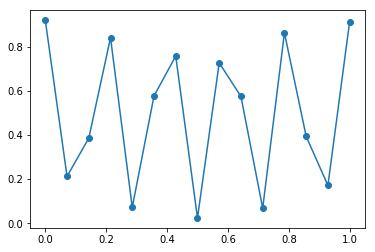

In [22]:
plot_t2_fit_over_data(results_t2_star,[0,1],'star')

# $T_2$-echo experiment

In [ ]:
stop_time = 1 * MICROSECOND
num_shots = 1000
num_points = 15
detune = 5e6
#qubits = [0,1,2]
t2_exp = generate_t2_echo_experiments(qubits, stop_time, detune, num_shots, num_points)